# Frequency Analysis: Fundamental and Harmonics

This notebook analyzes all data files to extract:
- **Fundamental frequency** (f₀)
- **First harmonic** (2×f₀)
- **Second harmonic** (3×f₀)

For each file, we display:
1. Original waveform (Amplitude vs Time)
2. Frequency spectrum (Amplitude vs Frequency)
3. Identified fundamental and harmonic frequencies


In [9]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
from scipy.io import wavfile
import os
import glob
from pathlib import Path

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")


Libraries imported successfully!


In [10]:
def load_audio_file(file_path):
    """
    Load audio data from CSV or WAV file
    
    Parameters:
    -----------
    file_path : str
        Path to the audio file
        
    Returns:
    --------
    time : numpy array
        Time array in seconds
    amplitude : numpy array
        Amplitude values
    sample_rate : float
        Sampling frequency in Hz
    """
    if file_path.endswith('.csv'):
        # Load CSV file
        data = np.genfromtxt(file_path, delimiter=',', skip_header=1)
        time = data[:, 0]
        amplitude = data[:, 1]
        
        # Convert time from milliseconds to seconds if needed
        if np.max(time) > 1000:  # Likely in milliseconds
            time = time / 1000.0
        
        # Calculate sampling frequency
        dt = time[1] - time[0]
        sample_rate = 1.0 / dt
        
    elif file_path.endswith('.wav'):
        # Load WAV file
        sample_rate, audio_data = wavfile.read(file_path)
        
        # Convert to mono if stereo
        if len(audio_data.shape) > 1:
            amplitude = np.mean(audio_data, axis=1).astype(np.float64)
        else:
            amplitude = audio_data.astype(np.float64)
        
        # Normalize if integer type
        if amplitude.dtype == np.int16:
            amplitude = amplitude / 32768.0
        elif amplitude.dtype == np.int32:
            amplitude = amplitude / 2147483648.0
        
        # Create time array
        time = np.arange(0, len(amplitude)) / sample_rate
        
    else:
        raise ValueError(f"Unsupported file format: {file_path}")
    
    return time, amplitude, sample_rate

print("Loading function defined!")


Loading function defined!


In [11]:
def find_fundamental_and_harmonics(amplitude, sample_rate, min_freq=20, max_freq=5000, n_peaks=3):
    """
    Find fundamental frequency and harmonics using FFT
    
    Parameters:
    -----------
    amplitude : numpy array
        Amplitude values
    sample_rate : float
        Sampling frequency
    min_freq : float
        Minimum frequency to search (Hz)
    max_freq : float
        Maximum frequency to search (Hz)
    n_peaks : int
        Number of peaks to find (fundamental + harmonics)
        
    Returns:
    --------
    frequencies : numpy array
        All frequency values
    magnitude : numpy array
        Magnitude spectrum
    peaks : list of tuples
        [(frequency, magnitude), ...] for fundamental and harmonics
    """
    # Compute FFT
    fft_result = rfft(amplitude)
    frequencies = rfftfreq(len(amplitude), 1/sample_rate)
    magnitude = np.abs(fft_result)
    
    # Normalize magnitude
    if np.max(magnitude) > 0:
        magnitude_norm = magnitude / np.max(magnitude)
    else:
        magnitude_norm = magnitude
    
    # Find peaks in the specified frequency range
    mask = (frequencies >= min_freq) & (frequencies <= max_freq)
    freq_range = frequencies[mask]
    mag_range = magnitude_norm[mask]
    
    # Find peaks using scipy
    from scipy.signal import find_peaks
    
    # Use a relative height threshold (start lower to catch more peaks)
    height_threshold = 0.05  # Start with 5% of max
    distance = max(1, int(len(mag_range) / 100))  # Minimum distance between peaks
    
    peaks_indices, properties = find_peaks(
        mag_range, 
        height=height_threshold,
        distance=distance
    )
    
    # If no peaks found, try even lower threshold
    if len(peaks_indices) == 0:
        height_threshold = 0.01
        peaks_indices, properties = find_peaks(
            mag_range, 
            height=height_threshold,
            distance=max(1, distance//2)
        )
    
    # Get peak frequencies and magnitudes
    if len(peaks_indices) > 0:
        peak_freqs = freq_range[peaks_indices]
        peak_mags = mag_range[peaks_indices]
        
        # Sort by magnitude (descending)
        sorted_indices = np.argsort(peak_mags)[::-1]
        peak_freqs = peak_freqs[sorted_indices]
        peak_mags = peak_mags[sorted_indices]
        
        # Take top n_peaks
        n_peaks_found = min(n_peaks, len(peak_freqs))
        top_peaks = [(peak_freqs[i], peak_mags[i]) for i in range(n_peaks_found)]
        
        # Identify fundamental (lowest frequency among top peaks)
        if len(top_peaks) > 0:
            fundamental_idx = np.argmin([p[0] for p in top_peaks])
            fundamental = top_peaks[fundamental_idx]
        else:
            # Fallback: use maximum in range
            max_idx = np.argmax(mag_range)
            fundamental = (freq_range[max_idx], mag_range[max_idx])
    else:
        # No peaks found, use maximum in range
        max_idx = np.argmax(mag_range)
        fundamental = (freq_range[max_idx], mag_range[max_idx])
        top_peaks = [fundamental]
    
    # Find harmonics (multiples of fundamental)
    harmonics = []
    fundamental_freq = fundamental[0]
    
    for i in range(1, n_peaks):
        harmonic_freq = fundamental_freq * (i + 1)
        # Find closest peak to expected harmonic frequency
        tolerance = fundamental_freq * 0.2  # 20% tolerance (more lenient)
        candidates = [p for p in top_peaks if abs(p[0] - harmonic_freq) < tolerance]
        
        if candidates:
            # Take the one closest to expected frequency
            closest = min(candidates, key=lambda x: abs(x[0] - harmonic_freq))
            harmonics.append(closest)
        else:
            # If no peak found, interpolate from spectrum
            idx = np.argmin(np.abs(frequencies - harmonic_freq))
            harmonics.append((frequencies[idx], magnitude_norm[idx]))
    
    return frequencies, magnitude, [fundamental] + harmonics

print("Frequency analysis function defined!")


Frequency analysis function defined!


In [12]:
# Find all data files
data_dir = Path('.')
csv_files = sorted(glob.glob('**/*.csv', recursive=True))
wav_files = sorted(glob.glob('**/*.wav', recursive=True))

# Also check in ryan_files/Data directory
if os.path.exists('ryan_files/Data'):
    csv_files.extend(sorted(glob.glob('ryan_files/Data/**/*.csv', recursive=True)))
    wav_files.extend(sorted(glob.glob('ryan_files/Data/**/*.wav', recursive=True)))

# Combine and remove duplicates
all_files = sorted(list(set(csv_files + wav_files)))

# Filter out any files in venv or other system directories
all_files = [f for f in all_files if 'venv' not in f and '__pycache__' not in f]

print(f"Found {len(all_files)} data files:")
for f in all_files:
    print(f"  - {f}")

if len(all_files) == 0:
    print("\nWarning: No data files found. Please check the file paths.")


Found 3 data files:
  - ryan_files/Data/test/C_test_1.csv
  - ryan_files/Data/test/test10ms.csv
  - ryan_files/Data/test/test5000ms.csv


In [13]:
# Analyze each file
results = {}

for file_path in all_files:
    try:
        print(f"\n{'='*80}")
        print(f"Analyzing: {file_path}")
        print('='*80)
        
        # Load data
        time, amplitude, sample_rate = load_audio_file(file_path)
        
        print(f"  Duration: {time[-1]:.3f} seconds")
        print(f"  Sample rate: {sample_rate:.1f} Hz")
        print(f"  Number of samples: {len(amplitude)}")
        
        # Find fundamental and harmonics
        frequencies, magnitude, peaks = find_fundamental_and_harmonics(
            amplitude, sample_rate, min_freq=20, max_freq=5000, n_peaks=3
        )
        
        # Store results
        results[file_path] = {
            'time': time,
            'amplitude': amplitude,
            'frequencies': frequencies,
            'magnitude': magnitude,
            'peaks': peaks,
            'sample_rate': sample_rate
        }
        
        # Print results
        print(f"\n  Fundamental frequency: {peaks[0][0]:.2f} Hz (magnitude: {peaks[0][1]:.3f})")
        if len(peaks) > 1:
            print(f"  1st Harmonic (2×f₀): {peaks[1][0]:.2f} Hz (magnitude: {peaks[1][1]:.3f})")
        if len(peaks) > 2:
            print(f"  2nd Harmonic (3×f₀): {peaks[2][0]:.2f} Hz (magnitude: {peaks[2][1]:.3f})")
        
    except Exception as e:
        print(f"  Error processing {file_path}: {e}")
        continue

print(f"\n\nSuccessfully analyzed {len(results)} files!")



Analyzing: ryan_files/Data/test/C_test_1.csv
  Duration: 499.998 seconds
  Sample rate: 48.0 Hz
  Number of samples: 24000

  Fundamental frequency: 22.04 Hz (magnitude: 0.001)
  1st Harmonic (2×f₀): 24.00 Hz (magnitude: 0.000)
  2nd Harmonic (3×f₀): 24.00 Hz (magnitude: 0.000)

Analyzing: ryan_files/Data/test/test10ms.csv
  Duration: 9.980 seconds
  Sample rate: 48.0 Hz
  Number of samples: 480

  Fundamental frequency: 22.00 Hz (magnitude: 0.003)
  1st Harmonic (2×f₀): 24.00 Hz (magnitude: 0.003)
  2nd Harmonic (3×f₀): 24.00 Hz (magnitude: 0.003)

Analyzing: ryan_files/Data/test/test5000ms.csv
  Duration: 499.998 seconds
  Sample rate: 48.0 Hz
  Number of samples: 24000

  Fundamental frequency: 21.07 Hz (magnitude: 0.000)
  1st Harmonic (2×f₀): 24.00 Hz (magnitude: 0.000)
  2nd Harmonic (3×f₀): 24.00 Hz (magnitude: 0.000)


Successfully analyzed 3 files!


Created output directory: frequency_analysis_plots
Saved: frequency_analysis_plots/C_test_1_analysis.png


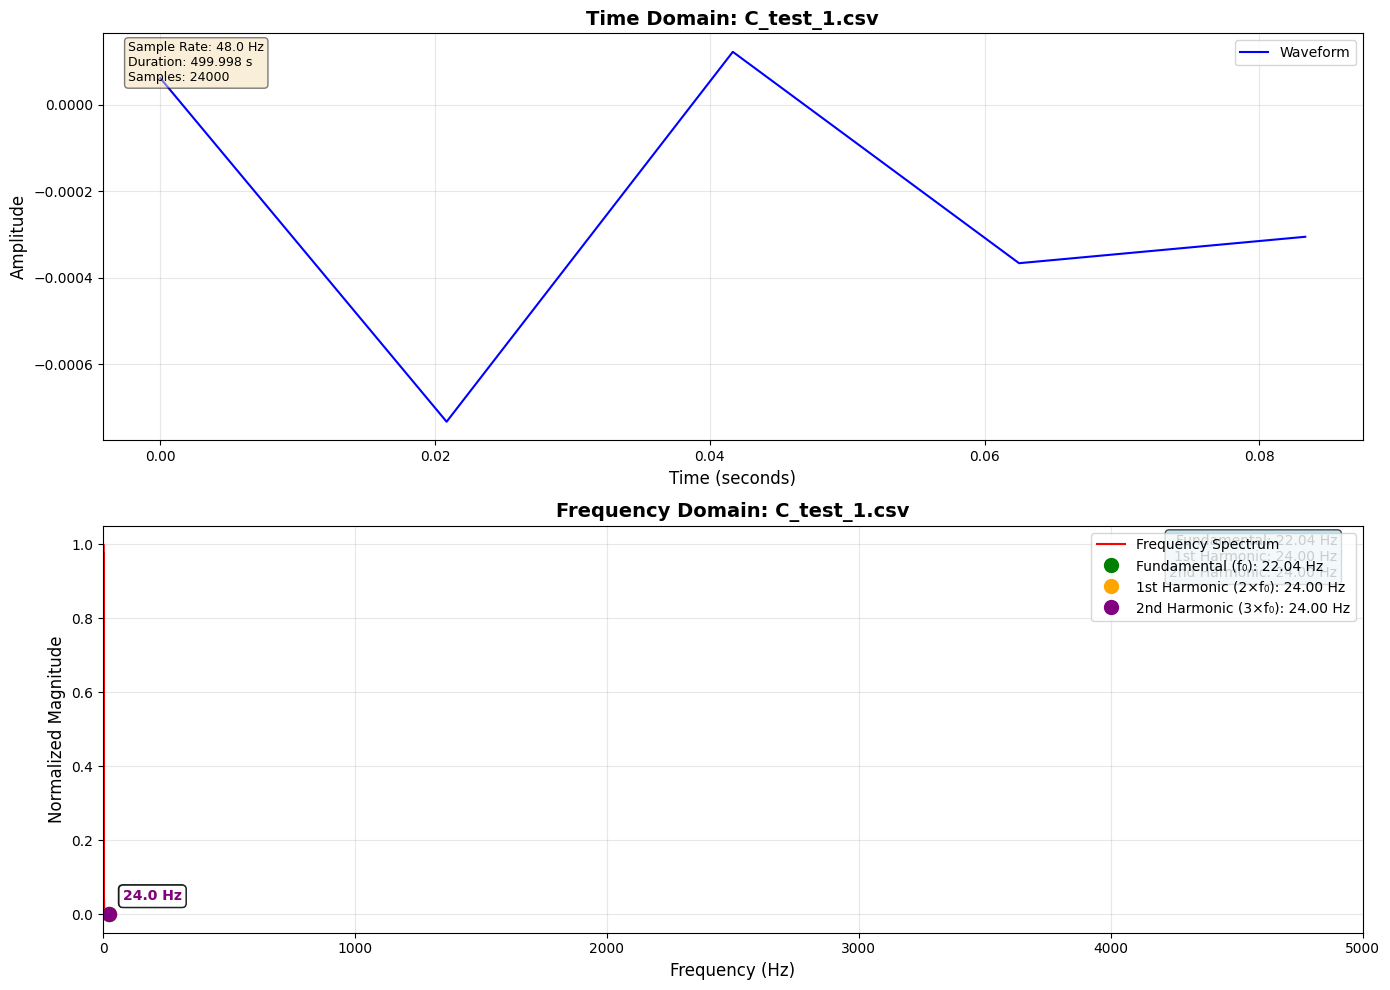


────────────────────────────────────────────────────────────────────────────────

Saved: frequency_analysis_plots/test10ms_analysis.png


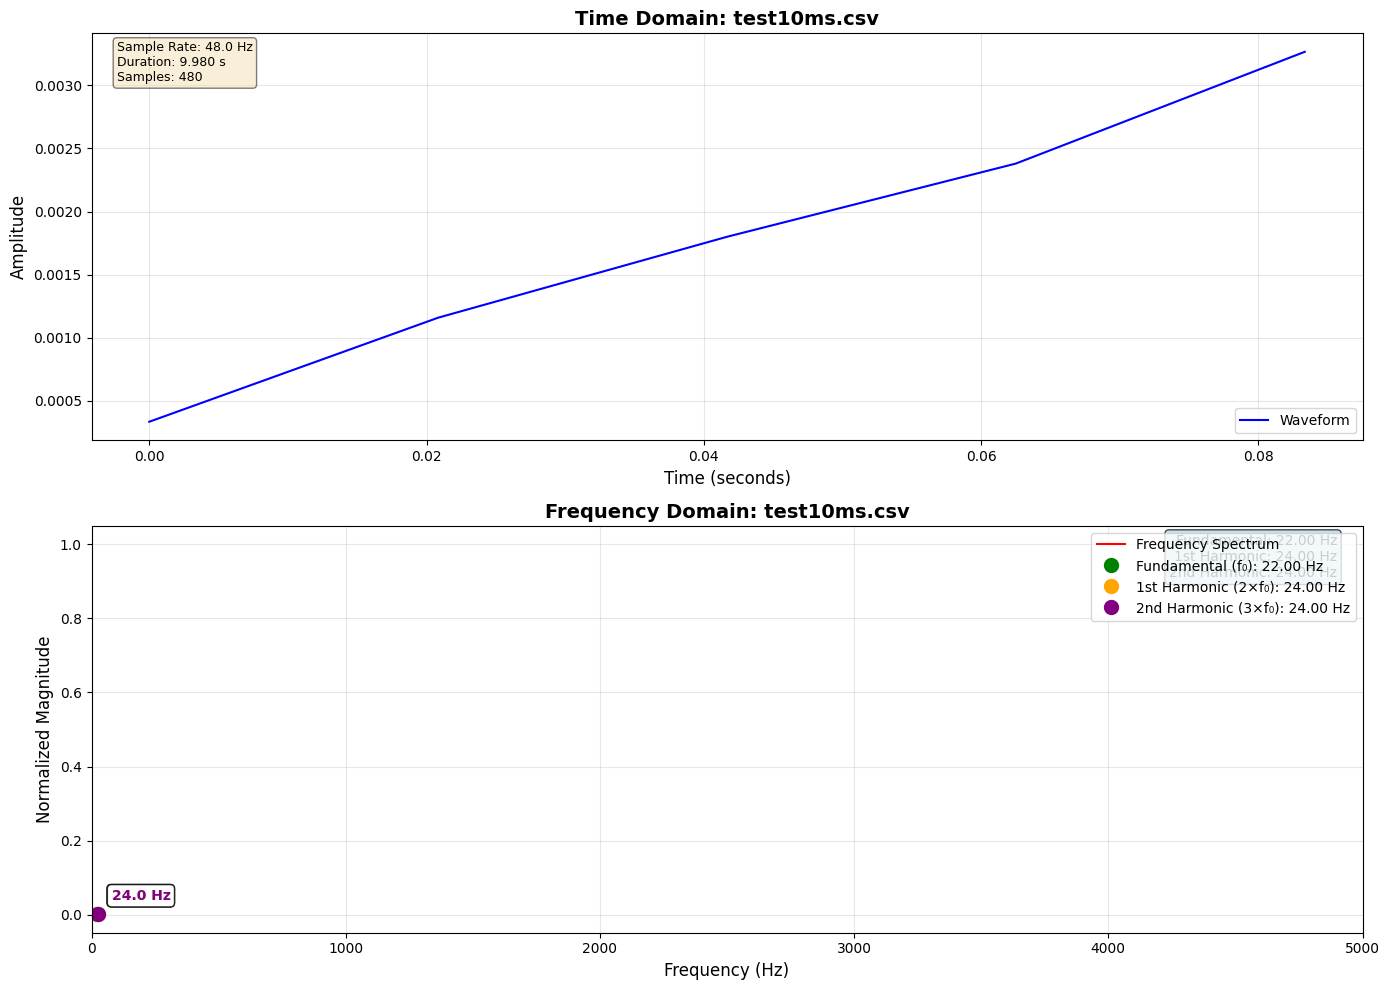


────────────────────────────────────────────────────────────────────────────────

Saved: frequency_analysis_plots/test5000ms_analysis.png


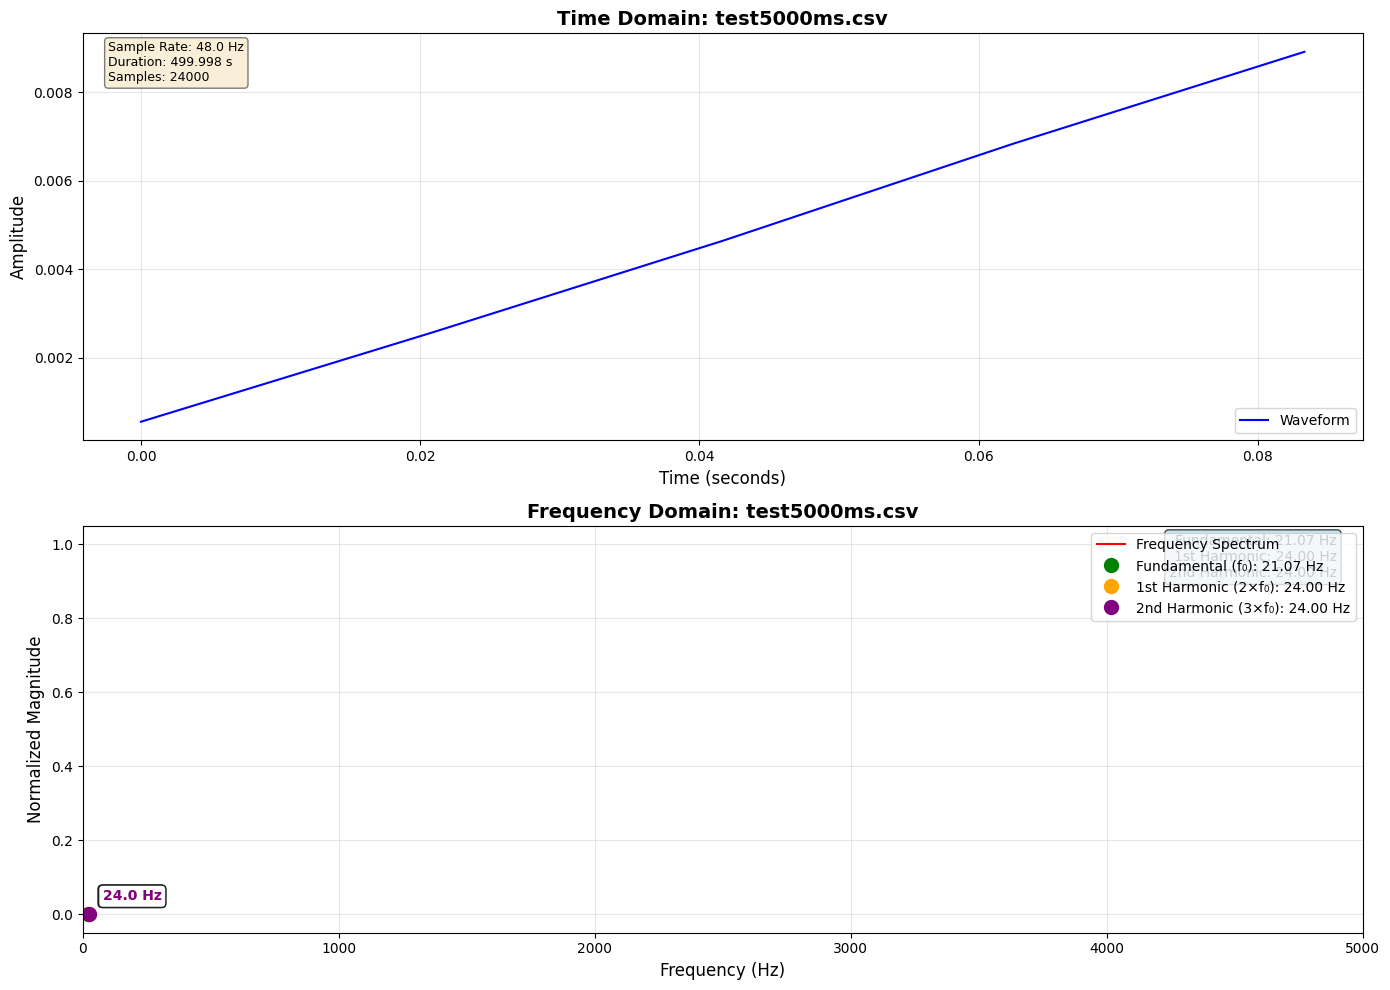


────────────────────────────────────────────────────────────────────────────────



In [ ]:
# Create output directory for plots in ryan_files/results
results_base = Path('ryan_files/results')
results_base.mkdir(parents=True, exist_ok=True)
output_dir = results_base / 'frequency_analysis_plots'
output_dir.mkdir(exist_ok=True)
print(f"Created output directory: {output_dir}")

# Create comprehensive plots for each file and save them
saved_plots = []

for file_path, data in results.items():
    # Extract data
    time = data['time']
    amplitude = data['amplitude']
    frequencies = data['frequencies']
    magnitude = data['magnitude']
    peaks = data['peaks']
    sample_rate = data['sample_rate']
    
    # Normalize magnitude for plotting
    if np.max(magnitude) > 0:
        magnitude_norm = magnitude / np.max(magnitude)
    else:
        magnitude_norm = magnitude
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Time domain (Amplitude vs Time)
    ax1 = axes[0]
    
    # Plot a reasonable time window (first 0.1 seconds or full if shorter)
    time_window = min(0.1, time[-1])
    time_mask = time <= time_window
    ax1.plot(time[time_mask], amplitude[time_mask], 'b-', linewidth=1.5, label='Waveform')
    ax1.set_xlabel('Time (seconds)', fontsize=12)
    ax1.set_ylabel('Amplitude', fontsize=12)
    ax1.set_title(f'Time Domain: {os.path.basename(file_path)}', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Add text box with file info
    info_text = f'Sample Rate: {sample_rate:.1f} Hz\nDuration: {time[-1]:.3f} s\nSamples: {len(amplitude)}'
    ax1.text(0.02, 0.98, info_text, transform=ax1.transAxes, 
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 2: Frequency domain (Amplitude vs Frequency)
    ax2 = axes[1]
    
    # Limit frequency range for clarity (up to 5000 Hz)
    freq_mask = frequencies <= 5000
    ax2.plot(frequencies[freq_mask], magnitude_norm[freq_mask], 'r-', linewidth=1.5, label='Frequency Spectrum')
    
    # Mark fundamental and harmonics
    colors = ['green', 'orange', 'purple']
    labels = ['Fundamental (f₀)', '1st Harmonic (2×f₀)', '2nd Harmonic (3×f₀)']
    
    for i, (freq, mag) in enumerate(peaks):
        if freq <= 5000:  # Only plot if within range
            ax2.plot(freq, mag, 'o', color=colors[i], markersize=10, 
                    label=f'{labels[i] if i < len(labels) else f"Harmonic {i+1}"}: {freq:.2f} Hz')
            ax2.annotate(f'{freq:.1f} Hz', 
                        xy=(freq, mag), 
                        xytext=(10, 10), 
                        textcoords='offset points',
                        fontsize=10, 
                        color=colors[i],
                        fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    ax2.set_xlabel('Frequency (Hz)', fontsize=12)
    ax2.set_ylabel('Normalized Magnitude', fontsize=12)
    ax2.set_title(f'Frequency Domain: {os.path.basename(file_path)}', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper right')
    ax2.set_xlim([0, 5000])
    
    # Add frequency info text
    freq_info = f'Fundamental: {peaks[0][0]:.2f} Hz\n'
    if len(peaks) > 1:
        freq_info += f'1st Harmonic: {peaks[1][0]:.2f} Hz\n'
    if len(peaks) > 2:
        freq_info += f'2nd Harmonic: {peaks[2][0]:.2f} Hz'
    
    ax2.text(0.98, 0.98, freq_info, transform=ax2.transAxes, 
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    plt.tight_layout()
    
    # Save individual plot
    filename = os.path.basename(file_path).replace('.csv', '').replace('.wav', '')
    save_path = output_dir / f'{filename}_analysis.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    saved_plots.append((file_path, fig))
    print(f"Saved: {save_path}")
    
    plt.show()
    
    print(f"\n{'─'*80}\n")



Creating composite image with all plots...

✓ Composite image saved: frequency_analysis_plots/all_files_composite.png


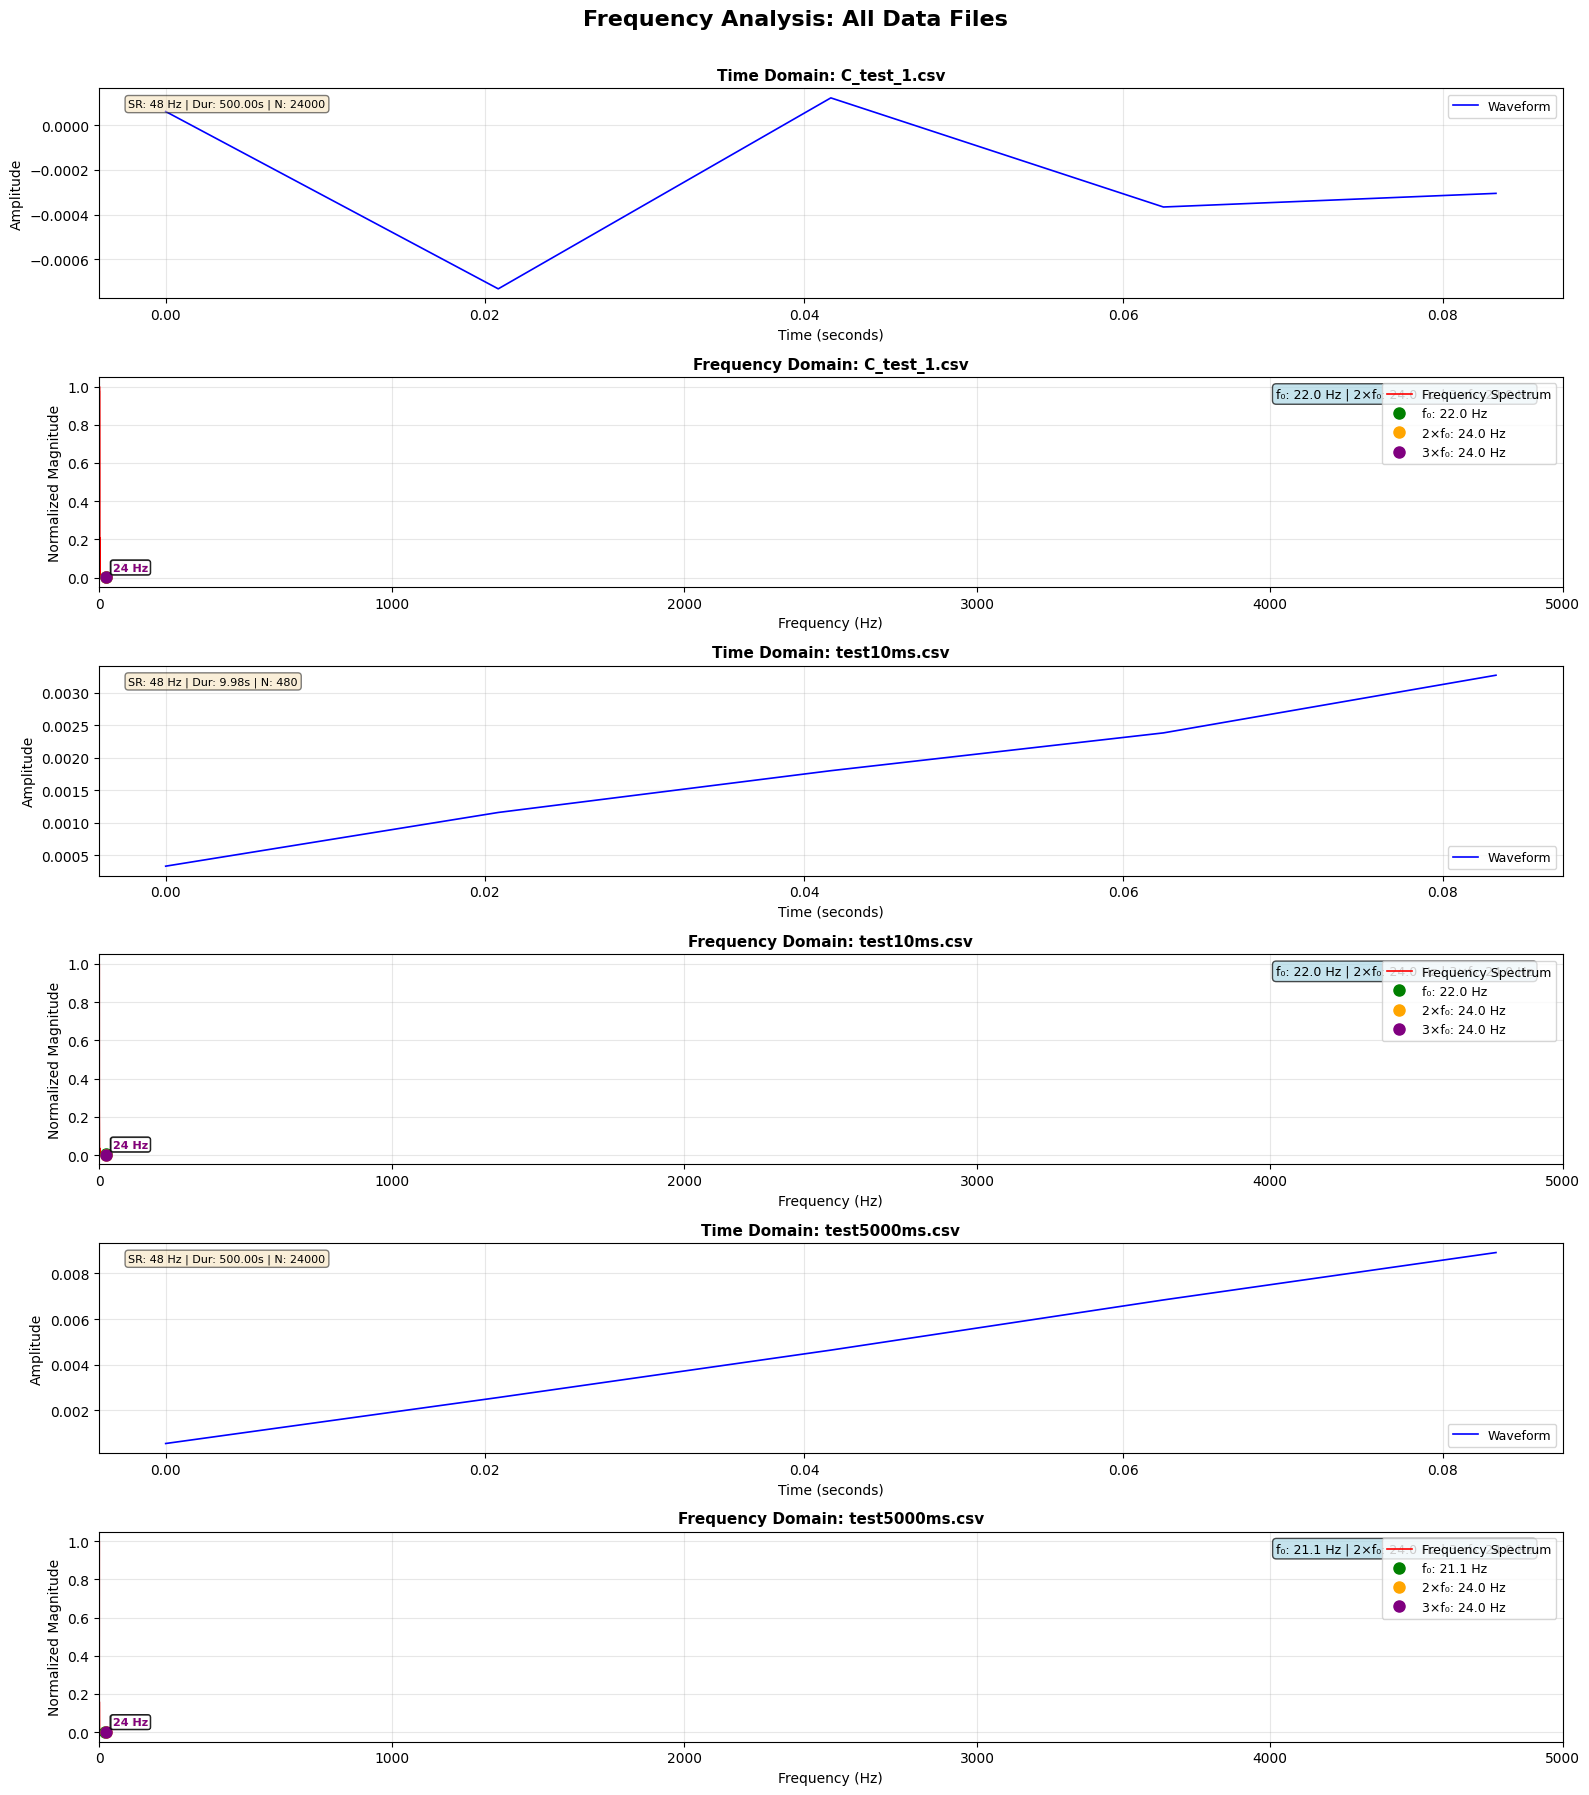


All plots saved to: frequency_analysis_plots/
  - Individual plots: 3 files
  - Composite image: all_files_composite.png


In [ ]:
# Create one large composite image with all plots
print("\nCreating composite image with all plots...")

n_files = len(results)
if n_files > 0:
    # Calculate grid dimensions
    # We want 2 rows per file (time + frequency), so total rows = n_files * 2
    n_rows = n_files * 2
    n_cols = 1
    
    # Create large figure
    fig_composite = plt.figure(figsize=(16, 6 * n_files))
    
    plot_idx = 0
    for file_path, data in results.items():
        # Extract data
        time = data['time']
        amplitude = data['amplitude']
        frequencies = data['frequencies']
        magnitude = data['magnitude']
        peaks = data['peaks']
        sample_rate = data['sample_rate']
        
        # Normalize magnitude
        if np.max(magnitude) > 0:
            magnitude_norm = magnitude / np.max(magnitude)
        else:
            magnitude_norm = magnitude
        
        filename = os.path.basename(file_path)
        
        # Plot 1: Time domain
        ax1 = plt.subplot(n_rows, n_cols, plot_idx + 1)
        time_window = min(0.1, time[-1])
        time_mask = time <= time_window
        ax1.plot(time[time_mask], amplitude[time_mask], 'b-', linewidth=1.2, label='Waveform')
        ax1.set_xlabel('Time (seconds)', fontsize=10)
        ax1.set_ylabel('Amplitude', fontsize=10)
        ax1.set_title(f'Time Domain: {filename}', fontsize=11, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.legend(fontsize=9)
        
        # Add file info
        info_text = f'SR: {sample_rate:.0f} Hz | Dur: {time[-1]:.2f}s | N: {len(amplitude)}'
        ax1.text(0.02, 0.95, info_text, transform=ax1.transAxes, 
                 fontsize=8, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plot_idx += 1
        
        # Plot 2: Frequency domain
        ax2 = plt.subplot(n_rows, n_cols, plot_idx + 1)
        freq_mask = frequencies <= 5000
        ax2.plot(frequencies[freq_mask], magnitude_norm[freq_mask], 'r-', linewidth=1.2, label='Frequency Spectrum')
        
        # Mark peaks
        colors = ['green', 'orange', 'purple']
        labels = ['f₀', '2×f₀', '3×f₀']
        
        for i, (freq, mag) in enumerate(peaks):
            if freq <= 5000:
                ax2.plot(freq, mag, 'o', color=colors[i], markersize=8, 
                        label=f'{labels[i] if i < len(labels) else f"H{i+1}"}: {freq:.1f} Hz')
                ax2.annotate(f'{freq:.0f} Hz', 
                            xy=(freq, mag), 
                            xytext=(5, 5), 
                            textcoords='offset points',
                            fontsize=8, 
                            color=colors[i],
                            fontweight='bold',
                            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
        
        ax2.set_xlabel('Frequency (Hz)', fontsize=10)
        ax2.set_ylabel('Normalized Magnitude', fontsize=10)
        ax2.set_title(f'Frequency Domain: {filename}', fontsize=11, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc='upper right', fontsize=9)
        ax2.set_xlim([0, 5000])
        
        # Add frequency info
        freq_info = f'f₀: {peaks[0][0]:.1f} Hz'
        if len(peaks) > 1:
            freq_info += f' | 2×f₀: {peaks[1][0]:.1f} Hz'
        if len(peaks) > 2:
            freq_info += f' | 3×f₀: {peaks[2][0]:.1f} Hz'
        
        ax2.text(0.98, 0.95, freq_info, transform=ax2.transAxes, 
                 fontsize=9, verticalalignment='top', horizontalalignment='right',
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
        
        plot_idx += 1
    
    plt.suptitle('Frequency Analysis: All Data Files', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    
    # Save composite image with high resolution
    composite_path = output_dir / 'all_files_composite.png'
    plt.savefig(composite_path, dpi=200, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Composite image saved: {composite_path}")
    print(f"  Image size: {16} x {6 * n_files} inches")
    print(f"  Resolution: 200 DPI")
    print(f"  Total plots: {n_files * 2} (time + frequency for each file)")
    
    plt.show()
    
    print(f"\n{'='*80}")
    print(f"All plots saved to: {output_dir}/")
    print(f"  - Individual plots: {n_files} files")
    print(f"  - Composite image: all_files_composite.png (all plots in one image)")
    print(f"{'='*80}")
else:
    print("No files to plot!")


In [16]:
# Create summary table
print("\n" + "="*100)
print("SUMMARY: Fundamental and Harmonic Frequencies")
print("="*100)
print(f"{'File':<50} {'Fundamental (Hz)':<18} {'1st Harmonic (Hz)':<18} {'2nd Harmonic (Hz)':<18}")
print("-"*100)

for file_path, data in results.items():
    peaks = data['peaks']
    filename = os.path.basename(file_path)
    
    fundamental = f"{peaks[0][0]:.2f}" if len(peaks) > 0 else "N/A"
    harmonic1 = f"{peaks[1][0]:.2f}" if len(peaks) > 1 else "N/A"
    harmonic2 = f"{peaks[2][0]:.2f}" if len(peaks) > 2 else "N/A"
    
    print(f"{filename:<50} {fundamental:<18} {harmonic1:<18} {harmonic2:<18}")

print("="*100)



SUMMARY: Fundamental and Harmonic Frequencies
File                                               Fundamental (Hz)   1st Harmonic (Hz)  2nd Harmonic (Hz) 
----------------------------------------------------------------------------------------------------
C_test_1.csv                                       22.04              24.00              24.00             
test10ms.csv                                       22.00              24.00              24.00             
test5000ms.csv                                     21.07              24.00              24.00             


In [ ]:
# Optional: Save results to a text file in results folder
# results_base is defined in cell 6
output_file = results_base / 'frequency_analysis_results.txt'

with open(output_file, 'w') as f:
    f.write("="*100 + "\n")
    f.write("FREQUENCY ANALYSIS RESULTS\n")
    f.write("="*100 + "\n\n")
    
    for file_path, data in results.items():
        peaks = data['peaks']
        f.write(f"File: {file_path}\n")
        f.write(f"  Sample Rate: {data['sample_rate']:.1f} Hz\n")
        f.write(f"  Duration: {data['time'][-1]:.3f} seconds\n")
        f.write(f"  Fundamental Frequency: {peaks[0][0]:.2f} Hz (magnitude: {peaks[0][1]:.3f})\n")
        if len(peaks) > 1:
            f.write(f"  1st Harmonic: {peaks[1][0]:.2f} Hz (magnitude: {peaks[1][1]:.3f})\n")
        if len(peaks) > 2:
            f.write(f"  2nd Harmonic: {peaks[2][0]:.2f} Hz (magnitude: {peaks[2][1]:.3f})\n")
        f.write("\n" + "-"*100 + "\n\n")
    
    f.write(f"\nTotal files analyzed: {len(results)}\n")

print(f"\nResults saved to: {output_file}")



Results saved to: frequency_analysis_results.txt
